In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Load the data
train = pd.read_csv('train_FD004.csv', low_memory=False)

# Define a function to calculate Fisher score using first 50 and last 50 samples of each engine
def fisher_score_sensor(df, sensor, start_cycles=50, end_cycles=50):
    begin_life = df[df['time, in cycles'] <= start_cycles][sensor]
    end_life = df[df['time, in cycles'] >= (df['time, in cycles'].max() - end_cycles + 1)][sensor]
    mean_diff = abs(begin_life.mean() - end_life.mean())
    within_var = begin_life.var() + end_life.var()
    return mean_diff / within_var

# Apply Fisher score calculation across each sensor
sensor_columns = [col for col in train.columns if col.startswith('sensor')]
fisher_scores = {sensor: fisher_score_sensor(train, sensor) for sensor in sensor_columns}

# Select the top sensors based on Fisher scores
# top_sensors = sorted(fisher_scores, key=fisher_scores.get, reverse=True)[:6]
top_sensors = sorted(fisher_scores, key=fisher_scores.get, reverse=True)[:1]
print("Top sensors selected based on Fisher score:", top_sensors)

# Calculate RUL for each engine
train['RUL'] = train.groupby('unit number')['time, in cycles'].transform(lambda x: x.max() - x)

# Apply EMA for each top sensor
ema_span = 50
for sensor in top_sensors:
    train[f'{sensor}_EMA'] = train.groupby('unit number')[sensor].transform(lambda x: x.ewm(span=ema_span, adjust=False).mean())

Top sensors selected based on Fisher score: ['sensor measurement 16']


In [2]:
train = train[['unit number', 'time, in cycles'] + [f'{sensor}' for sensor in top_sensors] + ['RUL']]
train.head()

,unit number,"time, in cycles",sensor measurement 16,RUL
0,1,1,0.02,320
1,1,2,0.02,319
2,1,3,0.02,318
3,1,4,0.02,317
4,1,5,0.02,316


In [3]:
# import matplotlib.pyplot as plt

# # Split the 'time, in cycles' data into 5 equal parts
# segments = 50
# train['segment'] = pd.qcut(train['time, in cycles'], q=segments, labels=False)

# # Create a 6-row by 5-column grid of subplots
# fig, axes = plt.subplots(nrows=len(top_sensors), ncols=segments, figsize=(200, 150), constrained_layout=True)

# # Plot time vs sensor data for each sensor and each segment
# for i, sensor in enumerate(top_sensors):
#     for seg in range(segments):
#         # Filter data for the current segment
#         segment_data = train[train['segment'] == seg]
        
#         # Plot time vs sensor data
#         axes[i, seg].plot(segment_data['time, in cycles'], segment_data[sensor], color='b', marker='o', linestyle='-', markersize=3)
#         axes[i, seg].set_title(f'Segment {seg + 1}')
        
#         # Set only the y-axis label for the first column and x-axis label for the last row
#         if seg == 0:
#             axes[i, seg].set_ylabel(sensor)
#         if i == len(top_sensors) - 1:
#             axes[i, seg].set_xlabel('Time, in cycles')

# # Main title for the entire figure
# plt.suptitle("Sensor Data across Segments of 'Time, in cycles'", fontsize=16)
# # Save the plot to a file with a large size and high resolution and the name should mention the number of segments
# plt.savefig(f"sensor_data_across_{segments}_segments.png", dpi=300)
# plt.show()

In [4]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Split the 'time, in cycles' data into 50 equal segments
# segments = 50
# train['segment'] = pd.qcut(train['time, in cycles'], q=segments, labels=False)

# # Iterate through each top sensor to create a separate cascade figure
# for i, sensor in enumerate(top_sensors):
#     # Create a 5x10 grid of subplots for the current sensor
#     fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(50, 25), constrained_layout=True)
    
#     # Plot data for each segment in the 5x10 grid
#     for seg in range(segments):
#         row = seg // 10  # Row index in the 5x10 grid
#         col = seg % 10   # Column index in the 5x10 grid

#         # Filter data for the current segment
#         segment_data = train[train['segment'] == seg]
        
#         # Plot time vs sensor data in the current subplot
#         axes[row, col].plot(segment_data['time, in cycles'], segment_data[sensor], color='b', marker='o', linestyle='-', markersize=3)
#         axes[row, col].set_title(f'Segment {seg + 1}')
        
#         # Set only the y-axis label for the first column and x-axis label for the last row
#         if col == 0:
#             axes[row, col].set_ylabel(sensor)
#         if row == 4:
#             axes[row, col].set_xlabel('Time, in cycles')

#     # Main title for the entire figure
#     fig.suptitle(f"Sensor Data for {sensor} across 50 Segments", fontsize=16)
    
#     # Save the plot to a file with a large size and high resolution
#     plt.savefig(f"{sensor}_data_across_{segments}_segments.png", dpi=300)
#     plt.close(fig)  # Close the figure to free up memory

In [5]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Split the 'time, in cycles' data into 50 equal segments
# segments = 50
# train['segment'] = pd.qcut(train['time, in cycles'], q=segments, labels=False)

# # Iterate through each top sensor to create a separate cascade figure
# for i, sensor in enumerate(top_sensors):
#     # Create a 5x10 grid of subplots for the current sensor
#     fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(50, 25), constrained_layout=True)
    
#     # Plot data for each segment in the 5x10 grid
#     for seg in range(segments):
#         row = seg // 10  # Row index in the 5x10 grid
#         col = seg % 10   # Column index in the 5x10 grid

#         # Filter data for the current segment
#         segment_data = train[train['segment'] == seg]
        
#         # Scatter plot of the data points
#         axes[row, col].scatter(segment_data['time, in cycles'], segment_data[sensor], color='b', marker='o', s=10)
#         # Dashed line joining the points
#         axes[row, col].plot(segment_data['time, in cycles'], segment_data[sensor], color='b', linestyle='--', linewidth=0.5)
#         axes[row, col].set_title(f'Segment {seg + 1}')
        
#         # Set only the y-axis label for the first column and x-axis label for the last row
#         if col == 0:
#             axes[row, col].set_ylabel(sensor)
#         if row == 4:
#             axes[row, col].set_xlabel('Time, in cycles')

#     # Main title for the entire figure
#     fig.suptitle(f"Sensor Data for {sensor} across 50 Segments", fontsize=16)
    
#     # Save the plot to a file with a large size and high resolution
#     plt.savefig(f"{sensor}_data_across_{segments}_segments.png", dpi=300)
#     plt.show()
#     plt.close(fig)  # Close the figure to free up memory

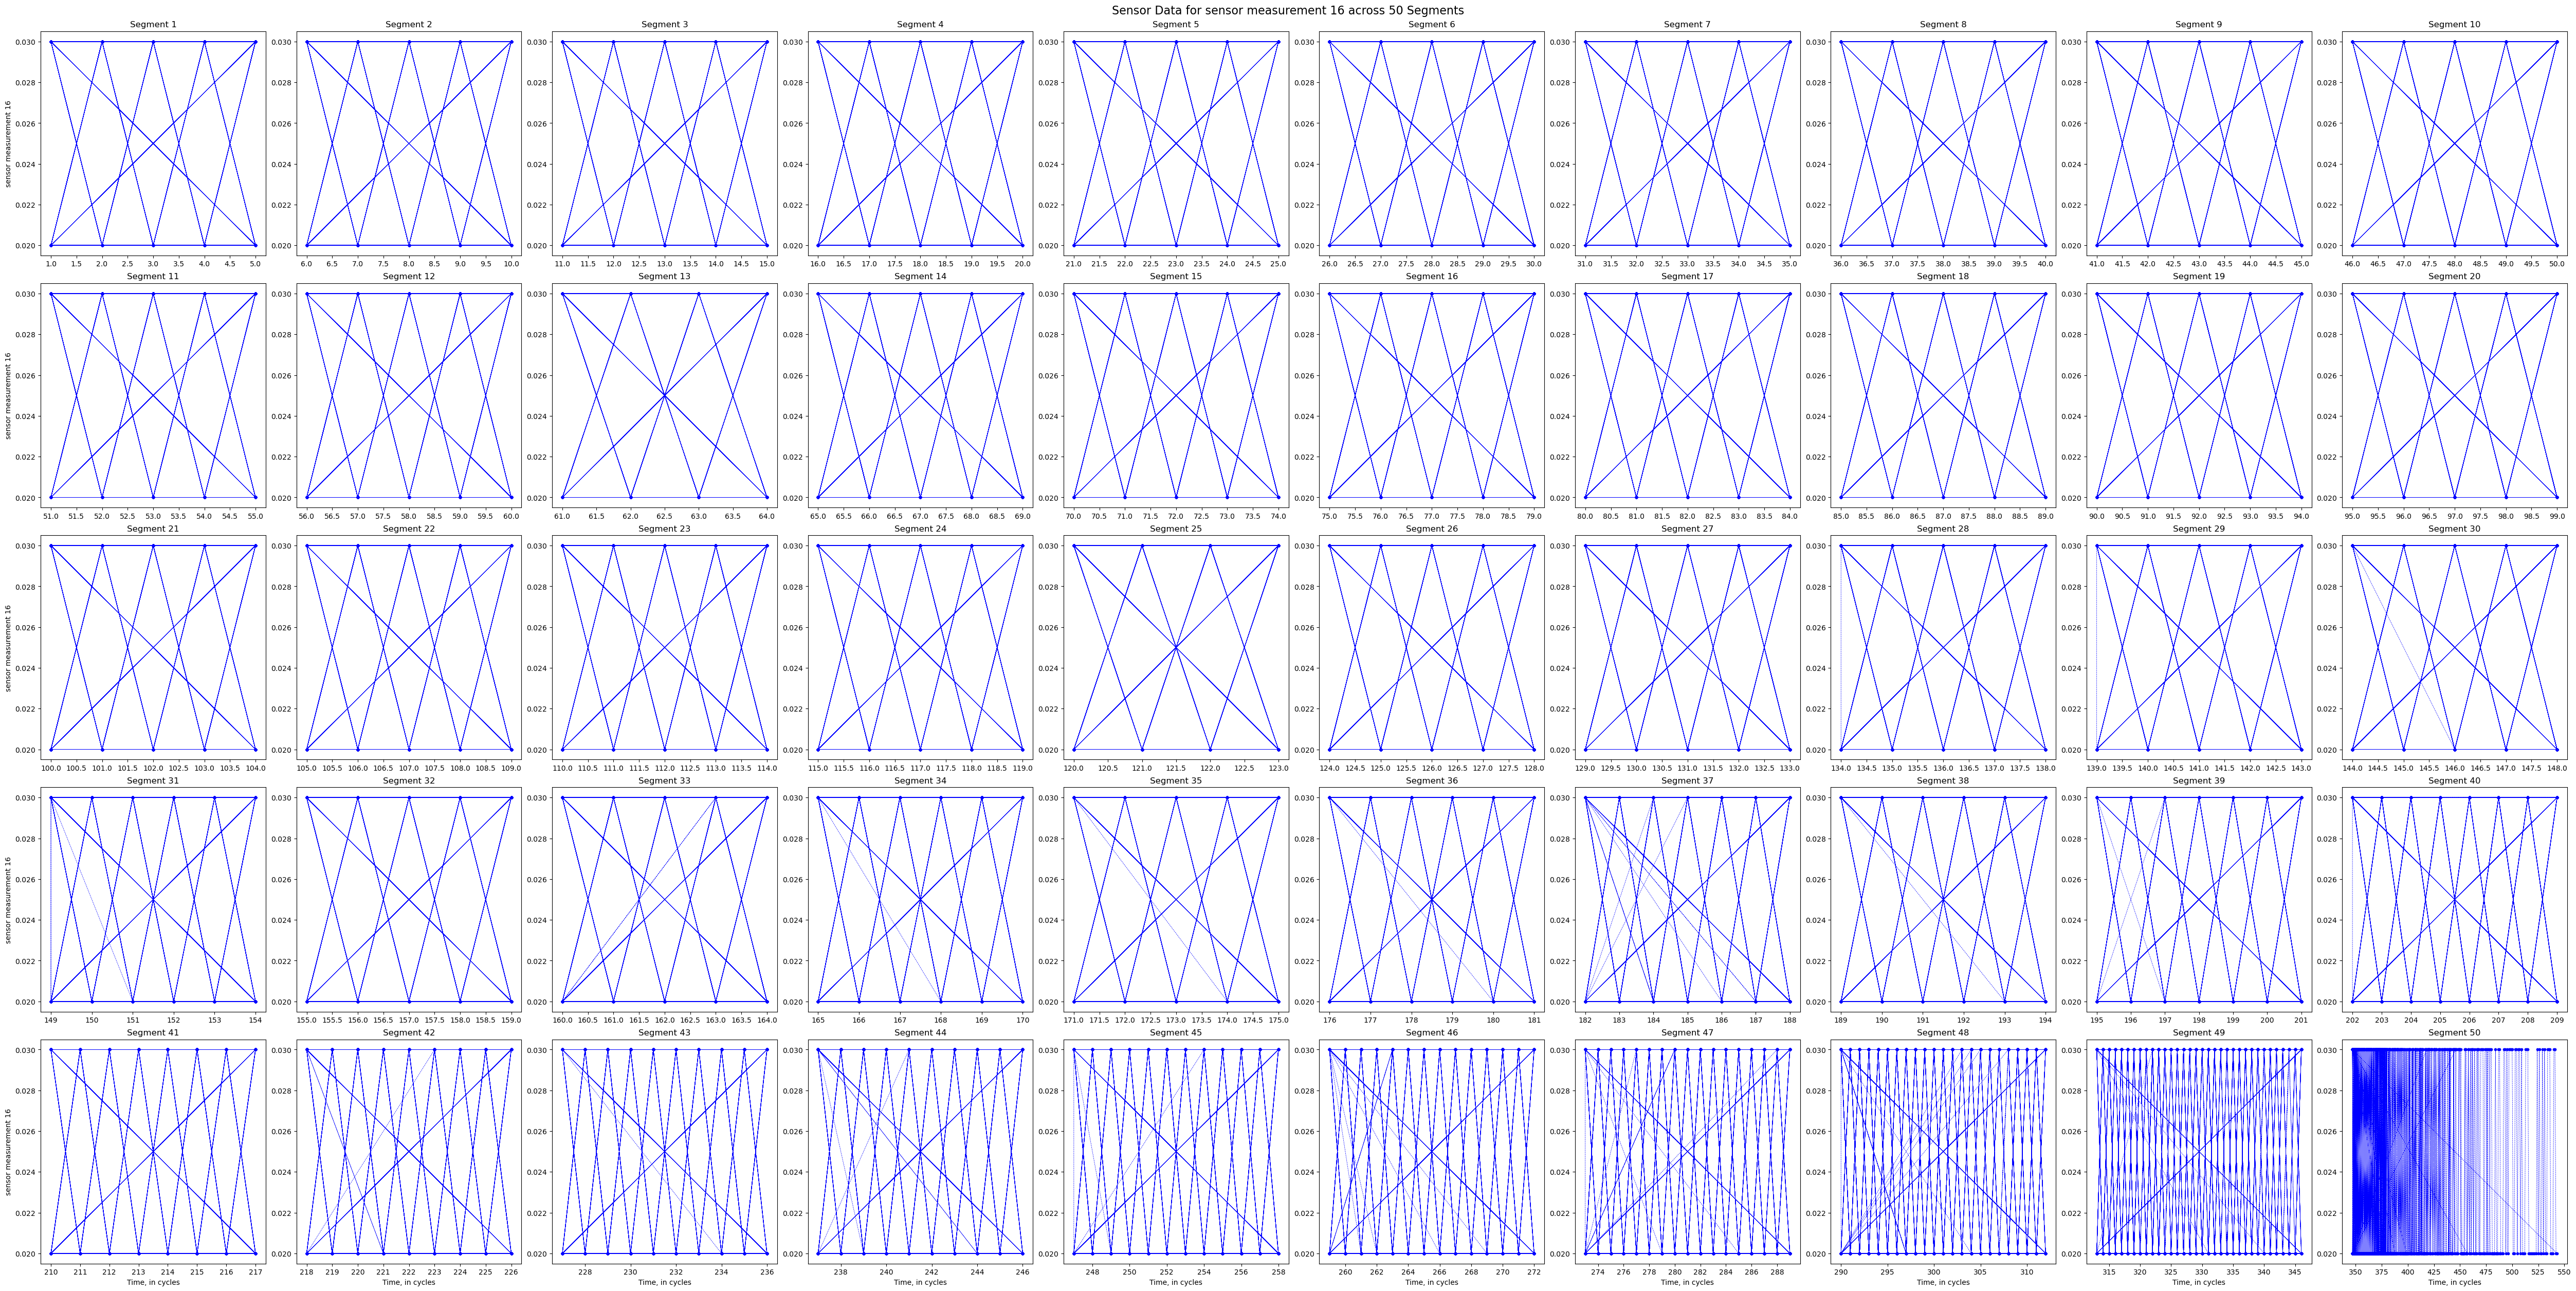

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Split the 'time, in cycles' data into 50 equal segments
segments = 50
train['segment'] = pd.qcut(train['time, in cycles'], q=segments, labels=False)

# Iterate through each top sensor to create a separate cascade figure
for i, sensor in enumerate(top_sensors):
    # Create a 5x10 grid of subplots for the current sensor
    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(50, 25), constrained_layout=True)
    
    # Plot data for each segment in the 5x10 grid
    for seg in range(segments):
        row = seg // 10  # Row index in the 5x10 grid
        col = seg % 10   # Column index in the 5x10 grid

        # Filter data for the current segment
        segment_data = train[train['segment'] == seg]
        
        # Scatter plot of the data points
        axes[row, col].scatter(segment_data['time, in cycles'], segment_data[sensor], color='b', marker='o', s=10)
        # # Dashed line joining the points
        axes[row, col].plot(segment_data['time, in cycles'], segment_data[sensor], color='b', linestyle='--', linewidth=0.5)
        axes[row, col].set_title(f'Segment {seg + 1}')
        
        # Set only the y-axis label for the first column and x-axis label for the last row
        if col == 0:
            axes[row, col].set_ylabel(sensor)
        if row == 4:
            axes[row, col].set_xlabel('Time, in cycles')

    # Main title for the entire figure
    fig.suptitle(f"Sensor Data for {sensor} across 50 Segments", fontsize=16)
    
    # Save the plot to a file with a large size and high resolution
    plt.savefig(f"{sensor}_data_across_{segments}_segments.png", dpi=300)
    plt.show()
    plt.close(fig)  # Close the figure to free up memory

In [7]:
# from scipy.stats import kstest, norm, expon, lognorm

# # Function to test goodness of fit for each distribution
# def goodness_of_fit_tests(data):
#     results = {}
    
#     # Test against a normal distribution
#     mean, std = norm.fit(data)
#     ks_stat, p_value = kstest(data, 'norm', args=(mean, std))
#     results['Normal'] = {'KS Statistic': ks_stat, 'p-value': p_value}
    
#     # Test against an exponential distribution
#     loc, scale = expon.fit(data)
#     ks_stat, p_value = kstest(data, 'expon', args=(loc, scale))
#     results['Exponential'] = {'KS Statistic': ks_stat, 'p-value': p_value}
    
#     # Test against a lognormal distribution
#     shape, loc, scale = lognorm.fit(data)
#     ks_stat, p_value = kstest(data, 'lognorm', args=(shape, loc, scale))
#     results['Lognormal'] = {'KS Statistic': ks_stat, 'p-value': p_value}
    
#     return results

# # Dictionary to store results for each sensor and segment
# fit_results = {sensor: {} for sensor in top_sensors}

# # Run goodness-of-fit tests for each sensor and each segment
# for sensor in top_sensors:
#     for seg in range(segments):
#         segment_data = train[train['segment'] == seg][sensor]
#         fit_results[sensor][f'Segment {seg + 1}'] = goodness_of_fit_tests(segment_data)

# # Display results
# for sensor, segments in fit_results.items():
#     print(f"\nGoodness of Fit Results for {sensor}:")
#     for segment, results in segments.items():
#         print(f"\n  {segment}:")
#         for dist, stats in results.items():
#             print(f"    {dist} - KS Statistic: {stats['KS Statistic']:.4f}, p-value: {stats['p-value']:.4f}")

In [8]:
# from scipy.stats import kstest, norm, expon, lognorm

# # Define the number of segments for splitting 'time, in cycles'
# segments = 5

# # Function to test goodness of fit for each distribution
# def goodness_of_fit_tests(data):
#     results = {}
    
#     # Test against a normal distribution
#     mean, std = norm.fit(data)
#     ks_stat, p_value = kstest(data, 'norm', args=(mean, std))
#     results['Normal'] = {'KS Statistic': ks_stat, 'p-value': p_value}
    
#     # Test against an exponential distribution
#     loc, scale = expon.fit(data)
#     ks_stat, p_value = kstest(data, 'expon', args=(loc, scale))
#     results['Exponential'] = {'KS Statistic': ks_stat, 'p-value': p_value}
    
#     # Test against a lognormal distribution
#     shape, loc, scale = lognorm.fit(data)
#     ks_stat, p_value = kstest(data, 'lognorm', args=(shape, loc, scale))
#     results['Lognormal'] = {'KS Statistic': ks_stat, 'p-value': p_value}
    
#     return results

# # Dictionary to store results for each sensor and segment
# fit_results = {sensor: {} for sensor in top_sensors}

# # Run goodness-of-fit tests for each sensor and each segment
# for sensor in top_sensors:
#     for seg in range(segments):  # Ensure 'segments' is an integer
#         segment_data = train[train['segment'] == seg][sensor]
#         segment_results = goodness_of_fit_tests(segment_data)
        
#         # Determine the best distribution based on KS Statistic and p-value
#         best_fit = None
#         best_stat = float('inf')  # Initialize with a high value to find the minimum KS Statistic
#         for dist, stats in segment_results.items():
#             ks_stat = stats['KS Statistic']
#             p_value = stats['p-value']
#             if ks_stat < best_stat and p_value > 0.05:  # Checking for good fit with p-value threshold
#                 best_stat = ks_stat
#                 best_fit = dist
        
#         # Store the results along with the best fit inference
#         fit_results[sensor][f'Segment {seg + 1}'] = {
#             'Results': segment_results,
#             'Best Fit': best_fit if best_fit else "No good fit (p-value < 0.05)"
#         }

# # Display results with inference
# for sensor, segments in fit_results.items():
#     print(f"\nGoodness of Fit Results for {sensor}:")
#     for segment, results in segments.items():
#         print(f"\n  {segment}:")
#         for dist, stats in results['Results'].items():
#             print(f"    {dist} - KS Statistic: {stats['KS Statistic']:.4f}, p-value: {stats['p-value']:.4f}")
        
#         best_fit = results['Best Fit']
#         print(f"    Best Fit Distribution: {best_fit}")

In [9]:
# from scipy import stats
# from scipy.integrate import IntegrationWarning
# import warnings

# # Suppress warnings for cleaner output
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=IntegrationWarning)

# # Define the number of segments for splitting 'time, in cycles'
# # segments = 5  # Set this to the intended number of segments

# # List of continuous distributions in scipy.stats, filtering known problematic ones
# continuous_distributions = [
#     dist for dist in dir(stats)
#     if isinstance(getattr(stats, dist), stats.rv_continuous) and dist not in ['erlang', 'halfcauchy', 'irwinhall']
# ]

# # Function to test goodness of fit for each distribution
# def goodness_of_fit_tests(data):
#     results = {}
    
#     for dist_name in continuous_distributions:
#         dist = getattr(stats, dist_name)
        
#         try:
#             # Fit the distribution to the data
#             params = dist.fit(data)
            
#             # Perform KS test using stats.kstest
#             ks_stat, p_value = stats.kstest(data, dist_name, args=params)
            
#             # Store KS Statistic in results
#             results[dist_name] = {'KS Statistic': ks_stat, 'p-value': p_value}
        
#         except Exception as e:
#             # If the distribution fails to fit, skip it
#             results[dist_name] = {'KS Statistic': float('inf'), 'p-value': 0}
#             print(f"Failed to fit {dist_name}: {e}")
    
#     return results

# # Dictionary to store results for each sensor and segment
# fit_results = {sensor: {} for sensor in top_sensors}

# # Run goodness-of-fit tests for each sensor and each segment
# for sensor in top_sensors:
#     for seg in range(segments):
#         segment_data = train[train['segment'] == seg][sensor]
#         segment_results = goodness_of_fit_tests(segment_data)
        
#         # Determine the best distribution based on KS Statistic alone
#         best_fit = min(segment_results, key=lambda x: segment_results[x]['KS Statistic'])
        
#         # Store the results along with the best fit inference
#         fit_results[sensor][f'Segment {seg + 1}'] = {
#             'Results': segment_results,
#             'Best Fit': best_fit if segment_results[best_fit]['KS Statistic'] < float('inf') else "No good fit"
#         }

# # Display results with inference
# for sensor, segments in fit_results.items():
#     print(f"\nGoodness of Fit Results for {sensor}:")
#     for segment, results in segments.items():
#         print(f"\n  {segment}:")
#         for dist, stats in results['Results'].items():
#             print(f"    {dist} - KS Statistic: {stats['KS Statistic']:.4f}, p-value: {stats['p-value']:.4f}")
        
#         best_fit = results['Best Fit']
#         print(f"    Best Fit Distribution: {best_fit}")

In [10]:
# from scipy import stats
# from scipy.integrate import IntegrationWarning
# import warnings

# # Suppress warnings for cleaner output
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=IntegrationWarning)

# # Define the number of segments for splitting 'time, in cycles'
# # segments = 5  # Set this to the intended number of segments

# # List of continuous distributions in scipy.stats, filtering known problematic ones
# continuous_distributions = [
#     dist for dist in dir(stats)
#     if isinstance(getattr(stats, dist), stats.rv_continuous) and dist not in ['erlang', 'halfcauchy', 'irwinhall']
# ]

# # Function to test goodness of fit for each distribution
# def goodness_of_fit_tests(data):
#     results = {}
    
#     for dist_name in continuous_distributions:
#         dist = getattr(stats, dist_name)
        
#         try:
#             # Fit the distribution to the data
#             params = dist.fit(data)
            
#             # Perform KS test using stats.kstest
#             ks_stat, p_value = stats.kstest(data, dist_name, args=params)
            
#             # Store KS Statistic in results
#             results[dist_name] = {'KS Statistic': ks_stat, 'p-value': p_value}
        
#         except Exception as e:
#             # If the distribution fails to fit, skip it
#             results[dist_name] = {'KS Statistic': float('inf'), 'p-value': 0}
#             print(f"Failed to fit {dist_name}: {e}")
    
#     return results

# # Dictionary to store results for each sensor and segment
# fit_results = {sensor: {} for sensor in top_sensors}

# # Run goodness-of-fit tests for each sensor and each segment
# for sensor in top_sensors:
#     for seg in range(segments):
#         segment_data = train[train['segment'] == seg][sensor]
#         segment_results = goodness_of_fit_tests(segment_data)
        
#         # Filter out entries with infinite KS Statistic
#         finite_results = {k: v for k, v in segment_results.items() if v['KS Statistic'] < float('inf')}
        
#         # Determine the best distribution based on KS Statistic alone, if there are finite values
#         if finite_results:
#             best_fit = min(finite_results, key=lambda x: finite_results[x]['KS Statistic'])
#         else:
#             best_fit = "No good fit"
        
#         # Store the results along with the best fit inference
#         fit_results[sensor][f'Segment {seg + 1}'] = {
#             'Results': segment_results,
#             'Best Fit': best_fit
#         }

# # Display results with inference
# for sensor, segments in fit_results.items():
#     print(f"\nGoodness of Fit Results for {sensor}:")
#     for segment, results in segments.items():
#         print(f"\n  {segment}:")
#         for dist, stats in results['Results'].items():
#             print(f"    {dist} - KS Statistic: {stats['KS Statistic']:.4f}, p-value: {stats['p-value']:.4f}")
        
#         best_fit = results['Best Fit']
#         print(f"    Best Fit Distribution: {best_fit}")

In [11]:
# from scipy import stats
# from scipy.integrate import IntegrationWarning
# import warnings
# from joblib import Parallel, delayed
# import pandas as pd

# # Suppress warnings for cleaner output
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=IntegrationWarning)

# # Define the number of segments for splitting 'time, in cycles'
# # segments = 5  # Set this to the intended number of segments

# # List of continuous distributions in scipy.stats, filtering known problematic ones
# continuous_distributions = [
#     dist for dist in dir(stats)
#     if isinstance(getattr(stats, dist), stats.rv_continuous) and dist not in ['erlang', 'halfcauchy', 'irwinhall']
# ]

# # Function to test goodness of fit for a single distribution
# def test_distribution(dist_name, data):
#     dist = getattr(stats, dist_name)
#     try:
#         # Fit the distribution to the data
#         params = dist.fit(data)
        
#         # Perform KS test
#         ks_stat, _ = stats.kstest(data, dist_name, args=params)
        
#         # Collect various statistics
#         dist_info = {
#             'KS Statistic': ks_stat,
#             'rvs': dist.rvs(*params, size=10),
#             'pdf': dist.pdf(data[0], *params),
#             'cdf': dist.cdf(data[0], *params),
#             'sf': dist.sf(data[0], *params),
#             'ppf': dist.ppf(0.5, *params),
#             'isf': dist.isf(0.5, *params),
#             'stats': dist.stats(*params),
#             'moment': dist.moment(1, *params)
#         }
        
#         return dist_name, dist_info
#     except Exception as e:
#         return dist_name, {'KS Statistic': float('inf'), 'error': str(e)}

# # Function to test goodness of fit across all distributions for a given data segment
# def goodness_of_fit_tests(data):
#     results = Parallel(n_jobs=-1)(delayed(test_distribution)(dist_name, data) for dist_name in continuous_distributions)
#     return dict(results)

# # Dictionary to store results for each sensor and segment
# fit_results = {sensor: {} for sensor in top_sensors}

# # Run goodness-of-fit tests for each sensor and each segment
# for sensor in top_sensors:
#     for seg in range(segments):
#         segment_data = train[train['segment'] == seg][sensor]
#         segment_results = goodness_of_fit_tests(segment_data)
        
#         # Determine the best distribution based on KS Statistic alone
#         best_fit = min(segment_results, key=lambda x: segment_results[x]['KS Statistic'])
        
#         # Store the results along with the best fit inference
#         fit_results[sensor][f'Segment {seg + 1}'] = {
#             'Results': segment_results,
#             'Best Fit': best_fit if segment_results[best_fit]['KS Statistic'] < float('inf') else "No good fit"
#         }

# # Display results with inference
# for sensor, segments in fit_results.items():
#     print(f"\nGoodness of Fit Results for {sensor}:")
#     for segment, results in segments.items():
#         print(f"\n  {segment}:")
#         for dist, metrics in results['Results'].items():
#             print(f"    {dist} - KS Statistic: {metrics['KS Statistic']:.4f}")
#             if 'error' not in metrics:
#                 print(f"      rvs: {metrics['rvs']}")
#                 print(f"      pdf at data[0]: {metrics['pdf']}")
#                 print(f"      cdf at data[0]: {metrics['cdf']}")
#                 print(f"      sf at data[0]: {metrics['sf']}")
#                 print(f"      ppf(0.5): {metrics['ppf']}")
#                 print(f"      isf(0.5): {metrics['isf']}")
#                 print(f"      stats (mean, variance): {metrics['stats']}")
#                 print(f"      moment (first moment): {metrics['moment']}")
        
#         best_fit = results['Best Fit']
#         print(f"    Best Fit Distribution: {best_fit}")

In [12]:
# from scipy.stats import kstest, norm, lognorm, expon, weibull_min, gamma
# import numpy as np

# # Define a function to calculate KS statistic for different distributions
# def ks_test_distributions(data):
#     distributions = {
#         'normal': norm,
#         'lognormal': lognorm,
#         'exponential': expon,
#         'weibull': weibull_min,
#         'gamma': gamma
#     }
    
#     ks_results = {}
#     for dist_name, dist in distributions.items():
#         # Fit distribution to data
#         if dist_name == 'lognormal':
#             params = dist.fit(np.log(data[data > 0]))  # apply log for log-normal fitting
#         else:
#             params = dist.fit(data)
        
#         # Perform KS test using the fitted distribution's CDF
#         ks_stat, _ = kstest(data, dist.cdf, args=params)
#         ks_results[dist_name] = ks_stat
    
#     # Get distribution with the smallest KS statistic
#     best_fit = min(ks_results, key=ks_results.get)
#     return best_fit, ks_results

# # Apply KS test to each top sensor's EMA data and select best-fitting distribution
# for sensor in top_sensors:
#     sensor_data = train[f'{sensor}'].dropna()  # Drop any NaN values
#     best_fit, ks_results = ks_test_distributions(sensor_data)
#     print(f"Best fit for {sensor}: {best_fit}")
#     print(f"KS Statistics: {ks_results}")

In [13]:
# from scipy.stats import kstest, norm, lognorm, expon, weibull_min, gamma
# import numpy as np

# # Define a function to calculate KS statistic for different distributions
# def ks_test_distributions(data):
#     distributions = {
#         'normal': norm,
#         'lognormal': lognorm,
#         'exponential': expon,
#         'weibull': weibull_min,
#         'gamma': gamma
#     }
    
#     ks_results = {}
#     for dist_name, dist in distributions.items():
#         # Fit distribution to data
#         if dist_name == 'lognormal':
#             params = dist.fit(np.log(data[data > 0]))  # apply log for log-normal fitting
#         else:
#             params = dist.fit(data)
        
#         # Perform KS test using the fitted distribution's CDF
#         ks_stat, _ = kstest(data, dist.cdf, args=params)
#         ks_results[dist_name] = ks_stat
    
#     # Get distribution with the smallest KS statistic
#     best_fit = min(ks_results, key=ks_results.get)
#     return best_fit, ks_results

# # Dictionary to store the best-fitting distribution for each sensor and segment
# best_fit_distributions = {sensor: {} for sensor in top_sensors}

# # Loop over each sensor and segment to perform KS test and identify the best-fitting distribution
# for sensor in top_sensors:
#     for segment in range(segments):
#         # Filter data for the specific sensor and segment
#         segment_data = train[train['segment'] == segment][f'{sensor}'].dropna()
        
#         # Only perform KS test if there is enough data in the segment
#         if len(segment_data) > 0:
#             best_fit, ks_results = ks_test_distributions(segment_data)
#             best_fit_distributions[sensor][segment] = {'best_fit': best_fit, 'ks_stats': ks_results}
#             print(f"Best fit for {sensor} in segment {segment}: {best_fit}")
#             print(f"KS Statistics: {ks_results}")
#         else:
#             print(f"Segment {segment} for {sensor} has insufficient data.")

In [ ]:
from scipy.stats import kstest, norm, lognorm, expon, weibull_min, gamma
import numpy as np

# Define a function to calculate KS statistic for different distributions
def ks_test_distributions(data):
    distributions = {
        'normal': norm,
        'lognormal': lognorm,
        'exponential': expon,
        'weibull': weibull_min,
        'gamma': gamma
    }
    
    ks_results = {}
    for dist_name, dist in distributions.items():
        # Fit distribution to data
        if dist_name == 'lognormal':
            params = dist.fit(np.log(data[data > 0]))  # apply log for log-normal fitting
        else:
            params = dist.fit(data)
        
        # Perform KS test using the fitted distribution's CDF
        ks_stat, _ = kstest(data, dist.cdf, args=params)
        ks_results[dist_name] = ks_stat
    
    # Get distribution with the smallest KS statistic
    best_fit = min(ks_results, key=ks_results.get)
    return best_fit, ks_results

# Dictionary to store the best-fitting distribution for each sensor and segment
best_fit_distributions = {sensor: {} for sensor in top_sensors}

# Loop over each sensor and segment to perform KS test and identify the best-fitting distribution
for sensor in top_sensors:
    for segment in range(segments):
        # Filter data for the specific sensor and segment
        segment_data = train[train['segment'] == segment][f'{sensor}'].dropna()
        
        # Only perform KS test if there is enough data in the segment
        if len(segment_data) > 0:
            best_fit, ks_results = ks_test_distributions(segment_data)
            best_fit_distributions[sensor][segment] = {'best_fit': best_fit, 'ks_stats': ks_results}
            print(f"Best fit for {sensor}:\n")
            print(f"Segment {segment+ 1}: {best_fit}")
            # print(f"KS Statistics: {ks_results}")
        else:
            print(f"Segment {segment+ 1} for {sensor} has insufficient data.")

c:\Users\soumy\miniconda3\envs\pytc\Lib\site-packages\scipy\stats\_continuous_distns.py:6617: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


Best fit for sensor measurement 16:

Segment 0: normal
Best fit for sensor measurement 16:

Segment 1: normal
Best fit for sensor measurement 16:

Segment 2: normal
Best fit for sensor measurement 16:

Segment 3: normal
Best fit for sensor measurement 16:

Segment 4: normal
Best fit for sensor measurement 16:

Segment 5: normal
Best fit for sensor measurement 16:

Segment 6: normal
Best fit for sensor measurement 16:

Segment 7: normal
Best fit for sensor measurement 16:

Segment 8: normal
Best fit for sensor measurement 16:

Segment 9: normal
Best fit for sensor measurement 16:

Segment 10: normal
Best fit for sensor measurement 16:

Segment 11: normal
Best fit for sensor measurement 16:

Segment 12: normal
Best fit for sensor measurement 16:

Segment 13: normal
Best fit for sensor measurement 16:

Segment 14: normal
Best fit for sensor measurement 16:

Segment 15: normal
Best fit for sensor measurement 16:

Segment 16: normal
Best fit for sensor measurement 16:

Segment 17: normal
Be